# Sturdy Statistics Quickstart
Download the notebook on github: https://github.com/ghodouss/SturdyStatsExamples/blob/main/notebooks/Quickstart.ipynb

In [4]:
# ! pip install sturdy-stats-sdk pandas numpy plotly seaborn

In [15]:
from sturdystats import Index, Job
import pandas as pd
import numpy as np
from plotly import express as px

API_KEY = None

## Upload Data

### Load Dataset

Earnings calls are large conference calls held by public companies following the publication of each earnings report.
Earnings calls give investors and analysts an opportunity to ask the company for clarification about its financial performance.
These calls, which are all publicly available, are a great source of information about companies: both what the companies highlight as major factors influencing their performance, and about what investors and analysts are most interested in learning about each company.

For this demo, we have prepared a dataset containing earnings calls for the companies _Google_, _Apple_, _Meta_, _Microsoft_, and _Nvidia_ for the years 2022 &mdash; 2024.
We have tagged each call with the stock ticker for the company, the quarter and year for the call, and the exact date the call took place.
Since earnings calls can move the stock price, we have also tagged each earnings call with the fractional change in the stock price on the day of the call.  (E.g., a `priceDelta` of -0.02 means that the stock price opened 2% lower the day after the earnings call than it did the day of the call.)

We can load and inspect the data as follows:

In [6]:
df = pd.read_parquet("data/tech_earnings_calls_oct_2024.parquet")
df.head()

,ticker,quarter,year,doc,published,title,author,priceDelta
0,GOOG,2024Q1,2023,"Operator: Welcome, everyone. Thank you for sta...",2024-01-30,GOOG 2024Q1,GOOG,-0.091346
1,GOOG,2023Q4,2023,"Operator: Welcome, everyone. Thank you for sta...",2023-10-24,GOOG 2023Q4,GOOG,-0.083095
2,GOOG,2023Q3,2023,"Operator: Welcome, everyone. Thank you for sta...",2023-07-25,GOOG 2023Q3,GOOG,0.061722
3,GOOG,2023Q2,2023,"Operator: Welcome, everyone. Thank you for sta...",2023-04-25,GOOG 2023Q2,GOOG,-0.021557
4,GOOG,2024Q4,2024,"Operator: Welcome, everyone. Thank you for sta...",2024-10-29,GOOG 2024Q4,GOOG,0.045372


In [10]:
from rich.pretty import pprint
pprint(df.iloc[:2].to_dict(orient='records'), max_string=80, indent_guides=False)

[
    {
        'ticker': 'GOOG',
        'quarter': '2024Q1',
        'year': 2023,
        'doc': 'Operator: Welcome, everyone. Thank you for standing by for the Alphabet Fourth Q'+50272,
        'published': '2024-01-30',
        'title': 'GOOG 2024Q1',
        'author': 'GOOG',
        'priceDelta': -0.09134566261367119
    },
    {
        'ticker': 'GOOG',
        'quarter': '2023Q4',
        'year': 2023,
        'doc': 'Operator: Welcome, everyone. Thank you for standing by for the Alphabet Third Qu'+46212,
        'published': '2023-10-24',
        'title': 'GOOG 2023Q4',
        'author': 'GOOG',
        'priceDelta': -0.08309488382740071
    }
]

### Upload

The basic unit for Sturdy Statistics workflows is the _index_.
An index stores your data, indexes it for search, and allows you to query your data using SQL.
An index also allows you to train our machine learning models for more sophisticated analysis.

Indexes are private to your API key, and each index associated with your API key has a unique _name_ and a unique identifier known as the _index_id_.
For this demo, we&rsquo;ll go ahead and make a new index with the name `demo_tech_earnings_calls_v1`:

The upload accepts a list of dictionaries (JSON records format).
Our only requirement is a plain-text field named `doc` which contains the text you want to analyze.
You can optionally provide a `doc_id` identifier for each document; if you do not provide one, we will generate one for you.

If you specify a `doc_id` which already exists, you can append metadata to the document (by leaving the `doc` field blank), or overwrite the `doc` content for that document (by placing new content in the `doc` field.)

In [ ]:
index = Index(API_key=API_KEY, name="demo_tech_earnings_calls_v001")
index.get_status()
res = index.upload(df.to_dict("records"))

### Train

Training requires no parameters at all… if you wish, you can automatically structure your data with a simple index.train(). However, our model can take advantage of more information about the data if you choose to provide it. We will refine the training using two optional arguments: regex_paragraph_splitter and doc_hierarchy.

In [ ]:
doc_hierarchy = ["quarter", "ticker"]
regex_paragraph_splitter = "\n"
job = index.train(dict(doc_hierarchy=doc_hierarchy, regex_paragraph_splitter=regex_paragraph_splitter), wait=False)
job.get_status()

### Crunching the numbers
Because we set `wait=False`, the train function call returns immediately with a `job` object.
This object allows us to poll the training job and check its status.
Training time scales linearly with the number of tokens in your dataset; it can take anywhere from a few minutes to &sim;48 hours.

We are training a custom model tuned to your data and your data alone.
Our Bayesian deep learning algorithm hierarchically organizes your data and identifies the data&rsquo;s recurring themes.
The model then orgainizes these themes into a discrete set of topics, and tags each word, sentence, paragraph, document with its thematic content.

While you wait for your model to finish training, we can take a look at one we have already trained:

Below we will build a series of visualization on an existing model. You can also use our public dashboard for a more interactive demo: https://sturdystatistics.com/analyze?folder_id=index_05a7cb07da764f0f81397b39ce65ab06&comp_fields=ticker,quarter&max_excerpts_per_doc=5&bar_plot_fields=ticker,quarter


## Explore

Once an index is trained, you treat your unstructured data as if it were structured. This opens the door to hundreds of rich visualizations

In [11]:
index_id = "index_05a7cb07da764f0f81397b39ce65ab06" ## Optionally Replace with your own if you want

index = Index(API_key=API_KEY, id=index_id)

Found an existing index with id="index_05a7cb07da764f0f81397b39ce65ab06".


### Search Documents
Note that our api automatically extracts the most relevent paragraph(s) from each doc.

In [14]:
res = index.query(search_query="ai")
docs = res["docs"]
doc = docs[0]

for doc in docs[:3]:
    print("Title:", doc["metadata"]["title"])
    print("Published:", doc["metadata"]["published"])
    print("Content:", doc["text"])
    print("")

Title: MSFT 2024Q2
Published: 2024-04-25
Content: Keith Weiss: Thank you, guys for taking the question and congratulations on a fantastic quarter. A lot of excitement in the marketplace around generative AI and the potential of these technologies, but there’s also a lot of investment going on behind them. It looks like Microsoft is on track to ramp CapEx over 50% year-on-year this year to over $50 billion. And there’s media speculation of more spending ahead with some reports talking about like $100 billion data center. So obviously, investments are coming well ahead of the revenue contribution. But what I was hoping for is that you could give us some color on how use as the management team, try to quantify the potential opportunities that underlie these investments because they are getting very big. And maybe if you could give us some hint on whether there's any truth to the potential of like $100 billion data center out there? Thank you so much.


Title: AAPL 2024Q2
Published: 2024-0

### Beyond individual documents

You can also perform search on the corpus as a whole. In order to support arbitrarily complex quantitative operations, we support SQL for query analysis. 

The `topicDiff` api pulls out the topics that are statistically significantly more prevalent in excerpts that contain `ai` compared to excerpts that do not contain `ai`. The parameter `q1` defines the group you are interested in and the parameter `q2` defines the group against which you want to compare q1.  

In [16]:
q1 = "search('ai')"
topic_df = pd.DataFrame(index.topicDiff(q1=q1, q2=f"NOT ({q1})", limit=50 )["topics"])
topic_df.head(5)[["short_title", "topic_group_short_title", "confidence", "prevalence"]]


,short_title,topic_group_short_title,confidence,prevalence
0,AI Cloud Services,AI Innovations,100,0.062975
1,AI Interaction and Engagement,Artificial Intelligence,100,0.060210
2,Microsoft Business Solutions,Microsoft Developments,100,0.046305
3,AI Workload Optimization,Business Strategies,100,0.039414
4,AI-Driven Data Processing,AI Innovations,100,0.034608


#### Visualize Topics
Note the size if each pie slice is the prevalence of the topic


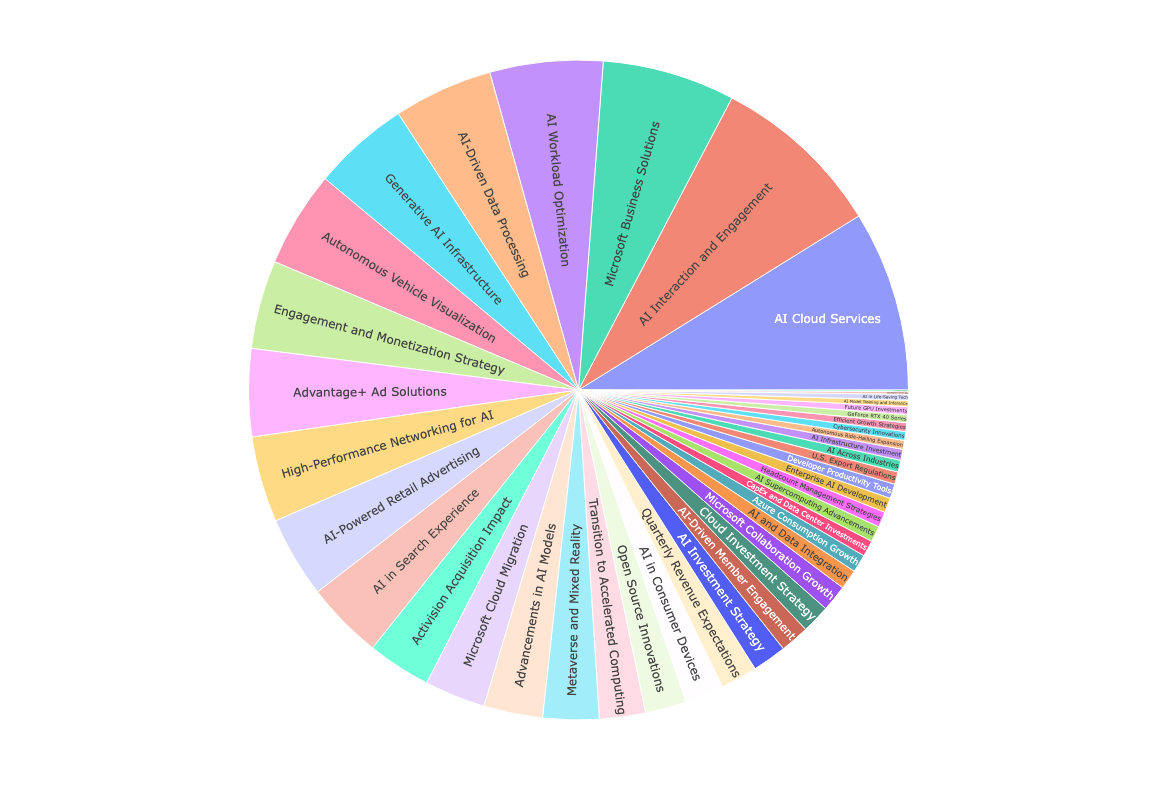

In [18]:
fig = px.sunburst(topic_df, path=["short_title"], values="prevalence", hover_data=["topic_id"])
fig.update_layout(width=800, height=800)
fig.show()

#### Organize Topics
Topics are automatically organized into topic groups. These topic groups to provide high-level organization on top of our extremely granular set of topics. 

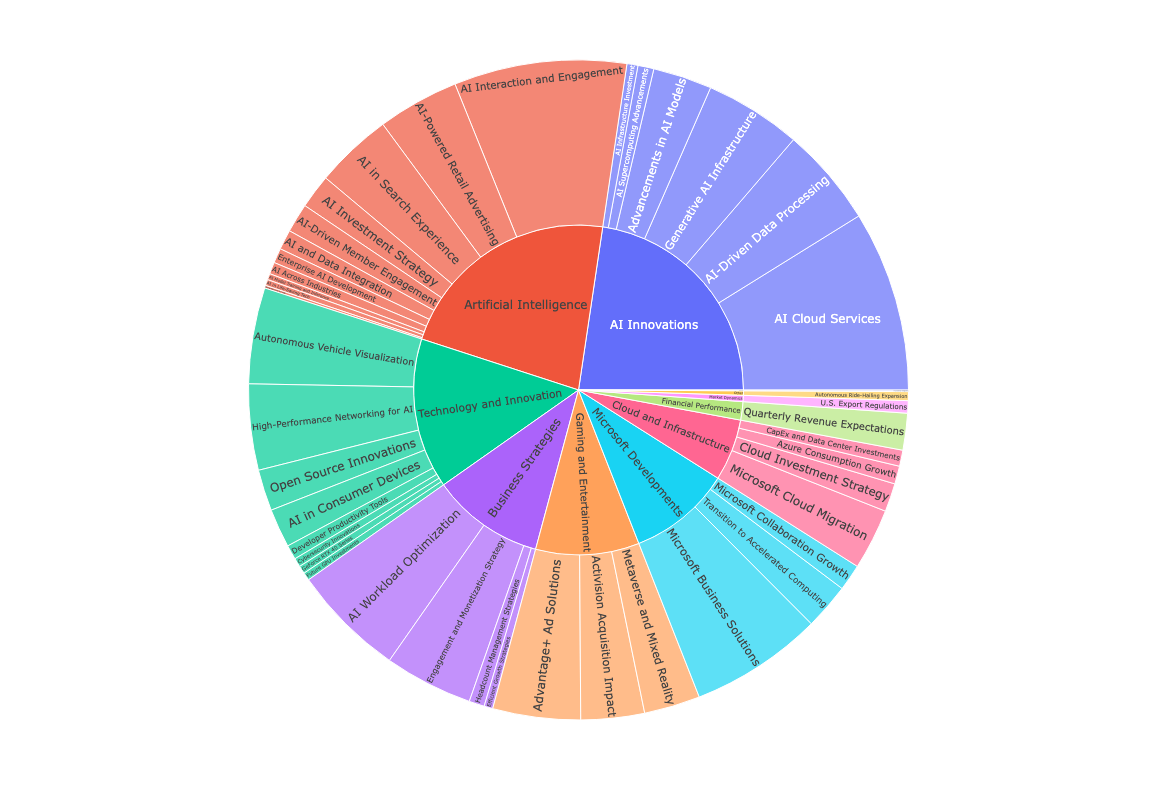

In [19]:
fig = px.sunburst(topic_df, path=["topic_group_short_title", "short_title"], values="prevalence", hover_data=["topic_id"] )
fig.update_layout(width=800, height=800)
fig.show()

### Topic Insights

A topic caught my eye: AI-Powered Retail Advertising. Topic 77 (the id is visible when hovering over the sunburst). Our api provides a topic summary out of the box.

In [20]:
topic_id = 77
row = topic_df.loc[topic_df.topic_id == topic_id].iloc[0]
print("Title:", row.short_title)
print("Summary:", row.executive_paragraph_summary)

Title: AI-Powered Retail Advertising
Summary: Recent discussions highlight the transformative role of AI in optimizing retail advertising strategies, focusing on the use of tools like Performance Max (PMax) and DemandGen to streamline workflows, enhance creative asset production, and drive higher conversion rates. Retailers are witnessing substantial improvements in return on ad spend (ROAS), with notable success stories including increased omni-channel revenue for a U.S. big-box retailer and significantly higher conversion rates for a global fashion brand. Advanced AI solutions aid in media buying processes, enabling advertisers to test varied creatives, while improvements to local inventory ads have boosted shopper confidence. Moreover, tools like virtual try-ons and optimized bidding strategies ensure that retailers remain competitive during critical shopping seasons, ultimately creating a more seamless experience for consumers.


#### Load exact data

Sumaries are helpful but the original data with examples are where the real work is done.

Fortunately, hopping between topics and documents is seamless

In [21]:
docs = index.query(topic_id=topic_id)["docs"]
for doc in docs[:3]:
    print("Title:", doc["metadata"]["title"])
    print("Published:", doc["metadata"]["published"])
    print("Content:", doc["text"])
    print("")

Title: GOOG 2024Q3
Published: 2024-07-23
Content: Across Search, PMax, DemandGen, and Retail, we're applying AI to streamline workflows, enhance creative asset production, and provide more engaging experiences for consumers. Listening to our customers, retailers in particular have welcomed AI-powered features to help scale the depth and breadth of their assets. For example, as part of a new and easier-to-use merchant center, we've expanded Product Studio, with tools that bring the power of Google AI to every business owner. You can upload a product image from the AI with something like, feature this product with Paris skyline in the background and Product Studio will generate campaign ready assets. I also hear great feedback from our customers on many of our other new AI-powered features. We're beta testing, virtual try on and shopping ads and plan to roll it out widely later this year. Feedback shows this feature gets 60% more high-quality views than other images and a higher click-ou

#### Trends over Time
I now want to ask some more high level questions ...

Google seems to be releasing a suite of tools leveraging Gemini for helping companies build advertisements. I want to know when this started and how focused the earnings calls have been on this product line each quarter.

Because our model statistically structures unstructured data at the word, sentence, paragraph, document and corpus level, we can actually just run basic sql queries as if our unstructured data was simply another quantitative field.

/Users/kian/miniconda3/envs/py11/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



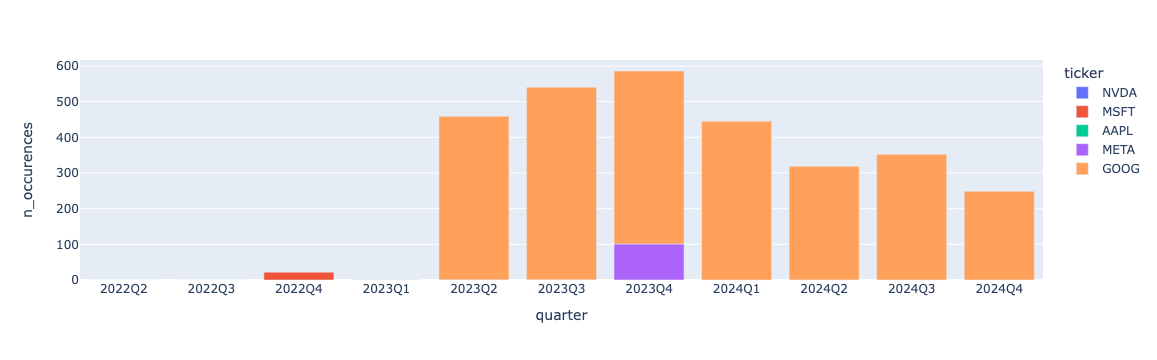

In [23]:
# Arrays are 1 indexed in our sql data store
df = pd.DataFrame(index.queryMeta(f"""
SELECT quarter, ticker, sum(sum_topic_counts[{topic_id+1}]) as n_occurences
FROM doc_meta 
GROUP BY quarter, ticker
ORDER BY quarter""") )

px.bar(df, x="quarter", y="n_occurences", color="ticker").show()

#### Helper Functions
Let's compose our work above into some helpers

In [24]:
def topicOverTime(topic_id, ticker):
    # Arrays are 1 indexed in our sql data store
    df = pd.DataFrame(index.queryMeta(f"""
    SELECT quarter, sum(sum_topic_counts[{topic_id+1}]) as n_occurences
    FROM doc_meta 
    WHERE ticker='{ticker}'
    GROUP BY quarter 
    ORDER BY quarter""") )
    df["topic_id"] = topic_id
    return df

def displayDocs(topic_id, quarter, ticker):
    docs = index.query(topic_id=topic_id, filters=(f"quarter='{quarter}' AND " if quarter is not None else "") + f"ticker='{ticker}'")["docs"]
    for doc in docs[:3]:
        print("Title:", doc["metadata"]["title"])
        print("Published:", doc["metadata"]["published"])
        print("Content:", doc["text"])
        print("")




### Cross Quarter Analysis

Instead of analyzing a topic across quarters, what if we could analyze quarters across topics. Specifically, let's answer the question: What was noteworthy about each quarter. This will provide us a much richer visualization as a jumping off point for as many topic specific analyses we could want.

#### Stacked Bar Plots

/Users/kian/miniconda3/envs/py11/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



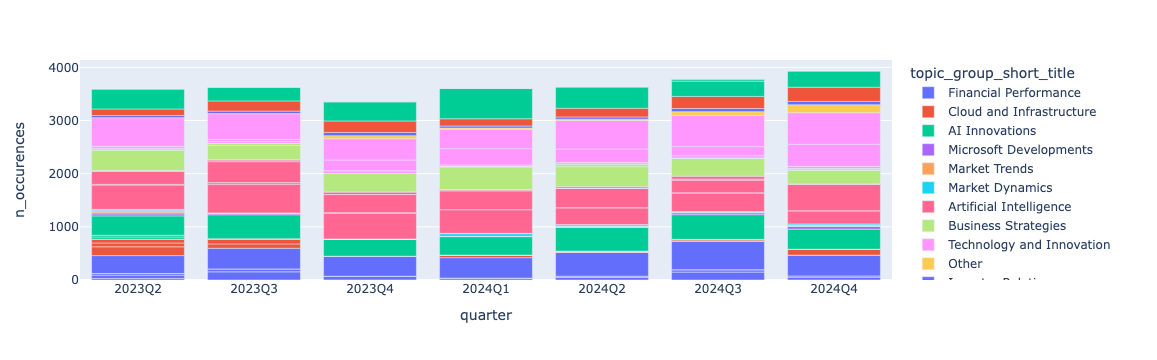

In [25]:
ticker = "GOOG"
quarters = pd.DataFrame(index.queryMeta(f"SELECT distinct(quarter) from doc_meta WHERE ticker='{ticker}'")).quarter
        

## This query compares one of google's quarters to all other quarters to pull out what made it distinct
## An alternative approach could be comparing the quarter only to those that came before it
## The api provides the ability to compare any 1 group to any other group and provides 
## The same high level structured overview
dfs = []
for q in quarters:
    tmp = pd.DataFrame(index.topicDiff(
        q1=f"ticker='{ticker}' AND quarter='{q}'", 
        q2=f"ticker='{ticker}' AND quarter!='{q}'",
        cutoff=1.0,
        limit=100
    )["topics"])
    tmp["quarter"] = q
    dfs.append(tmp)
topic_df = pd.concat(dfs).sort_values("quarter")
counts_df = pd.concat([ topicOverTime(t, ticker) for t in topic_df.topic_id.unique() ])

df = pd.merge(counts_df, topic_df.drop_duplicates(subset="short_title").drop(columns="quarter"), on="topic_id")
px.bar(df, x="quarter", y="n_occurences", color="topic_group_short_title", hover_data=["short_title", "topic_id"])

#### Back to the data

Title: Autonomous Ride-Hailing Expansion


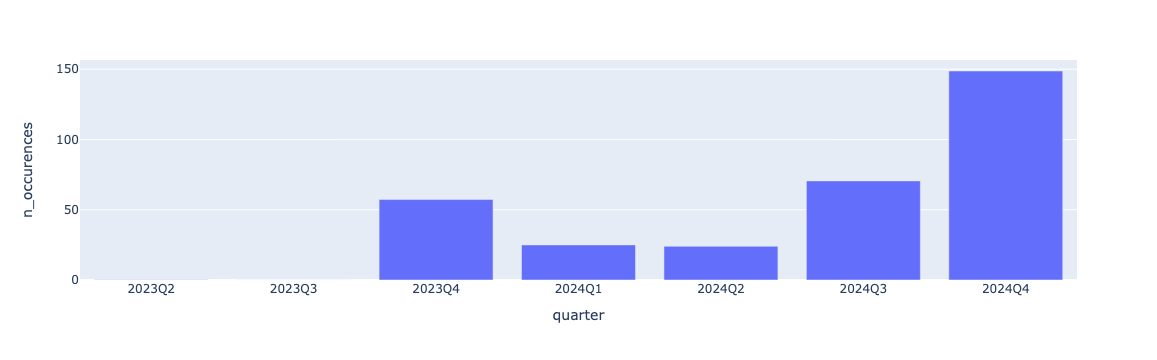

Title: GOOG 2024Q4
Published: 2024-10-29
Content: At Made by Google, we unveiled our latest Pixel 9 series of devices featuring advanced AI models, including Gemini Nano. We have seen strong demand for these devices, and they've already received multiple awards. Turning to Other Bets. I want to highlight Waymo, the biggest part of our portfolio. Waymo is now a clear technical leader within the autonomous vehicle industry and creating a growing commercial opportunity. Over the years, Waymo has been infusing cutting-edge AI into its work. Now each week, Waymo is driving more than 1 million fully autonomous miles and serves over 150,000 paid rides. The first time any AV company has reached this kind of mainstream use. Through its expanded network and operations partnership with Uber in Austin and Atlanta, plus a new multiyear partnership with Hyundai, Waymo will bring fully autonomous driving to more people and places. By developing a universal driver, Waymo has multiple paths to market. 

In [30]:
topic_id = 69
row = topic_df.loc[topic_df.topic_id == topic_id].iloc[0]
print("Title:", row.short_title)
px.bar(topicOverTime(topic_id, ticker), y="n_occurences", x="quarter").show()
displayDocs(topic_id, None, ticker)